# Introduction

This Jupyter Notebook is part of a comprehensive analysis exploring the interplay between recreational trail access and real estate valuation in Auburn, CA. The primary objective is to enhance property valuation models by integrating geospatial data on trailhead locations and activity density from personal Strava heatmaps. The notebook includes detailed steps for data preparation, feature engineering, and exploratory data analysis (EDA) of real estate sales data (auburn_home_sales.csv), trailhead coordinates (trailheads.csv), and GPS activity heatmaps (grid_*.csv). Each section of the notebook is designed to provide insights into how proximity to recreational amenities can influence property values, paving the way for more nuanced and accurate Automated Valuation Models (AVMs). The code also demonstrates methods for efficient data handling and visualization techniques that can be adapted for similar geospatial analyses.

In [6]:
#import libraries
import os
import argparse
import math
import zipfile
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

from scipy import stats
from scipy.spatial import KDTree
from scipy.spatial.distance import euclidean
from scipy.stats import shapiro

from google.colab import files

import statsmodels.api as sm

# Geospatial libraries
!pip install contextily
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from shapely.wkt import loads

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.3 MB/s eta 0:00:00


In [7]:
# Configuration
!mkdir auburn_data hypo_tests cluster_plots score_plots strava_heatmaps cluster_mapping

mkdir: cannot create directory ‘auburn_data’: File exists
mkdir: cannot create directory ‘strava_heatmaps’: File exists


# Data Pre-Processing

Combine the five .csv files containing scrapped Zillow real estate sales First, identify the original data files and then combine them into a single data frame:


In [8]:
#Download Kaggle dataset
# !pip install Kaggle #install kaggle API

#uplaod your Kaggle API key
files.upload()

#Kaggle API key
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [9]:
!kaggle datasets download tayloredwards0/informing-property-valuation-with-recreation-data --force

!unzip -o informing-property-valuation-with-recreation-data.zip "auburn_home_sales.csv" -d ./auburn_data/
!unzip -o informing-property-valuation-with-recreation-data.zip "trailheads.csv" -d ./auburn_data/
!unzip -o informing-property-valuation-with-recreation-data.zip "grid_*.csv" -d ./strava_heatmaps/

Dataset URL: https://www.kaggle.com/datasets/tayloredwards0/informing-property-valuation-with-recreation-data
License(s): CC0-1.0
100% 365k/365k [00:00<00:00, 640kB/s]
100% 365k/365k [00:00<00:00, 639kB/s]
Archive:  informing-property-valuation-with-recreation-data.zip
  inflating: ./auburn_data/auburn_home_sales.csv  
Archive:  informing-property-valuation-with-recreation-data.zip
  inflating: ./auburn_data/trailheads.csv  
Archive:  informing-property-valuation-with-recreation-data.zip
  inflating: ./strava_heatmaps/grid_1.csv  
  inflating: ./strava_heatmaps/grid_10.csv  
  inflating: ./strava_heatmaps/grid_25.csv  


In [10]:
# Read the data itno dataframes
auburn_df = pd.read_csv('auburn_data/auburn_home_sales.csv')
print(auburn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1376 entries, 0 to 1375
Data columns (total 93 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   zpid                                                          1369 non-null   float64
 1   rawHomeStatusCd                                               1369 non-null   object 
 2   marketingStatusSimplifiedCd                                   1369 non-null   object 
 3   imgSrc                                                        1376 non-null   object 
 4   hasImage                                                      1195 non-null   object 
 5   detailUrl                                                     1376 non-null   object 
 6   statusType                                                    1376 non-null   object 
 7   statusText                                                    1376 no

Select only the desired attributes from the Zillow data:

In [11]:
columns_to_keep = [
    'beds',
    'baths',
    'latLong.latitude',
    'latLong.longitude',
    'hdpData.homeInfo.price',
    'hdpData.homeInfo.lotAreaValue',
    'hdpData.homeInfo.lotAreaUnit'
    ]

auburn_df = auburn_df[columns_to_keep]
auburn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1376 entries, 0 to 1375
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   beds                           1357 non-null   float64
 1   baths                          1357 non-null   float64
 2   latLong.latitude               1376 non-null   float64
 3   latLong.longitude              1376 non-null   float64
 4   hdpData.homeInfo.price         1369 non-null   float64
 5   hdpData.homeInfo.lotAreaValue  1362 non-null   float64
 6   hdpData.homeInfo.lotAreaUnit   1362 non-null   object 
dtypes: float64(6), object(1)
memory usage: 75.4+ KB


Check each object for missing values show how many missing values are in each.

In [12]:
missing_values = auburn_df.isna().sum()

print(missing_values)

beds                             19
baths                            19
latLong.latitude                  0
latLong.longitude                 0
hdpData.homeInfo.price            7
hdpData.homeInfo.lotAreaValue    14
hdpData.homeInfo.lotAreaUnit     14
dtype: int64


Remove all observations with missing bed, bath, time on Zillow, area, or price data. Check to see how many observations have missing values.

In [13]:
auburn_df = auburn_df.dropna()
missing_values = auburn_df.isna().sum()

print(missing_values)

beds                             0
baths                            0
latLong.latitude                 0
latLong.longitude                0
hdpData.homeInfo.price           0
hdpData.homeInfo.lotAreaValue    0
hdpData.homeInfo.lotAreaUnit     0
dtype: int64


Now, convert all of the area data to acres that is not already in units of acres


In [14]:
auburn_df.loc[auburn_df['hdpData.homeInfo.lotAreaUnit'] == 'sqft', 'hdpData.homeInfo.lotAreaValue'] /= 43560

auburn_df.drop(['hdpData.homeInfo.lotAreaUnit'], axis=1, inplace=True)

auburn_df.rename(columns={
    'hdpData.homeInfo.lotAreaValue': 'area',
    'hdpData.homeInfo.price': 'price',
    'latLong.latitude': 'lat',
    'latLong.longitude': 'lon'
}, inplace=True)

print(auburn_df.head())

   beds  baths        lat         lon      price      area
0   3.0    3.0  38.922077 -121.073715   700000.0  0.315404
1   5.0    3.0  38.868380 -121.093650   790000.0  0.439509
2   4.0    2.0  38.926178 -121.049740   865000.0  1.300000
3   3.0    2.0  38.935770 -121.076270   720000.0  1.610000
4   3.0    4.0  38.931560 -121.076760  2150000.0  3.000000


<ipython-input-14-d34eb985456c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auburn_df.drop(['hdpData.homeInfo.lotAreaUnit'], axis=1, inplace=True)
<ipython-input-14-d34eb985456c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auburn_df.rename(columns={


# Remove outliers



In [15]:
Q1 = auburn_df.quantile(0.25)
Q3 = auburn_df.quantile(0.75)
IQR = Q3 - Q1
coef = 2

# Define a mask for values that are not outliers
mask = ~((auburn_df < (Q1 - coef * IQR)) | (auburn_df > (Q3 + coef * IQR))).any(axis=1)

# Apply the mask to filter the DataFrame
auburn_df_filtered = auburn_df[mask]

print(f"Original DataFrame size: {auburn_df.shape[0]}")
print(f"New DataFrame size after outlier removal: {auburn_df_filtered.shape[0]}")


auburn_df = auburn_df_filtered

Original DataFrame size: 1350
New DataFrame size after outlier removal: 1114


Read in the trailhead location data.

In [16]:
trailhead_df = pd.read_csv('./auburn_data/trailheads2.csv')
trailhead_df.head(30)

Trailhead   Longitude   Latitude
0          Stagecoach -121.053968  38.911316
1          Confluence -121.037956  38.916861
2                FHDL -120.983104  38.942747
3            Overlook -121.068540  38.889909
4          Oregon Bar -121.064117  38.875557
5             Cardiac -121.059283  38.864731
6             Canal 2 -121.068421  38.886565
7             Canal 3 -121.066412  38.878130
8         Eagles Nest -121.069961  38.864870
9             Pioneer -121.059758  38.862846
10        Robie Point -121.053532  38.892057
11            Canal 4 -121.068236  38.869833
12            Canal 1 -121.067498  38.892624
13      Murphy's Gate -121.058649  38.902152
14             Quarry -121.036772  38.912239
15      Training Hill -121.038910  38.914273
16   Lower Stagecoach -121.045565  38.915337
17  Culvert/Connector -121.022744  38.930964
18       Hidden Falls -121.162453  38.958562
19              Flood -121.048327  38.918750
20        Gold Street -121.064374  38.893232
21      Olive Orchard -121.058623  38.903118
22          Manzanita -121.055136  38.907127
23            Pioneer -121.059758  38.862846
24             Marina -121.060685  38.890058
25         Rio Camino -121.058642  38.889270
26    Pioneer Express -121.067852  38.872573
27                ABP -121.066617  38.877619
28                VDL -121.070351  38.876892
29      Eagles Nest 2 -121.068076  38.871986

In [17]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Use 3,958.7613 miles
    radius = 3958.7613

    # Calculate the result
    distance = radius * c

    return distance

Calculate each listing's Trailhead Score as the average distance of the five closest trailheads.

In [18]:
for index, row in auburn_df.iterrows():
  list_lat = row["lat"]
  list_lon = row["lon"]

  distances = []

  # Calculate distance for each trailhead
  for th_index, th_row in trailhead_df.iterrows():
    th_name = th_row['Trailhead']
    th_lat = th_row['Latitude']
    th_lon = th_row['Longitude']
    distance = haversine(list_lat, list_lon, th_lat, th_lon)

    distances.append(distance)


  # Sort by distance and select the top 5
  th_sorted = sorted(distances)
  closest_five = th_sorted[0:5]
  #print("closest_five =",closest_five)
  th_score = 1/np.mean(closest_five)

  auburn_df.at[index, 'trailhead_score'] = th_score

<ipython-input-18-7021516a7def>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auburn_df.at[index, 'trailhead_score'] = th_score


Drop attributes that we have used for feature addition and unit conversions

In [19]:
# Drop the lat-long data that has been used and no longer needed
# auburn_df.drop(['lat','long'], axis = 1, inplace = True)

In [20]:
auburn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 0 to 1375
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   beds             1114 non-null   float64
 1   baths            1114 non-null   float64
 2   lat              1114 non-null   float64
 3   lon              1114 non-null   float64
 4   price            1114 non-null   float64
 5   area             1114 non-null   float64
 6   trailhead_score  1114 non-null   float64
dtypes: float64(7)
memory usage: 101.9 KB


We need to scale the data becasue of the magnitude of certain attributes. For example, the time on Zillow and price attributes are significantly larger than the trailhead score or beds and baths attributes.

In [21]:
# Drop the lat-long data. We aren't using it to cluster at this point
temp = auburn_df.drop(['lat','lon'], axis = 1)

# Create a StandardScaler object
scaler = StandardScaler()

# Apply the scaler to the entire DataFrame
scaled_data = scaler.fit_transform(temp)

# The result is a NumPy array. Convert it back to a DataFrame with the same column names
scaled_auburn_df = pd.DataFrame(scaled_data, columns=temp.columns)

# Display the first few rows of the scaled DataFrame
scaled_auburn_df.head()

beds     baths     price      area  trailhead_score
0 -0.272357  0.768439  0.368513 -0.095296        -0.584520
1  2.298876  0.768439  0.822356  0.399481        -0.416353
2  1.013260 -0.485833  1.200559  3.830063         0.114889
3 -0.272357 -0.485833  0.126463 -0.026739         3.542812
4 -0.272357 -0.485833 -0.085330 -0.560144        -1.011960

# K-Means Clustering

First, let's determine the optimal quantity of clusters using the silhoutte score. The score is a measure of how similar an object is to it's own cluster as opposed to others.

Optimal number of clusters: 4


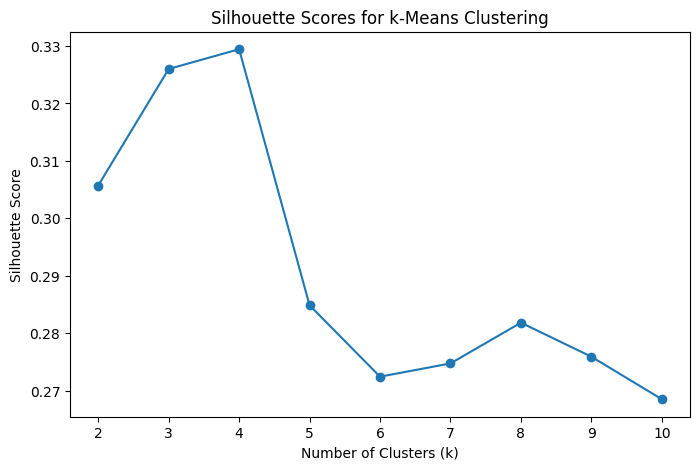

In [22]:
# Load dataset
kmeans_dataset = scaled_auburn_df.copy()

# Range of potential clusters to evaluate
range_of_clusters = range(2, 11)

# Dictionary to hold the silhouette scores for each k
silhouette_scores = {}

for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    cluster_labels = kmeans.fit_predict(kmeans_dataset)

    # Silhouette score
    score = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores[k] = score
    # print(f'Silhouette Score for {k} clusters: {score}')

# Find the optimal number of clusters based on silhouette score
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f'Optimal number of clusters: {optimal_k}')


# Visualize silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range_of_clusters, silhouette_scores.values(), marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for k-Means Clustering')
plot_path = './score_plots/kmeans_trailhead_silhouette.png'
plt.savefig(plot_path)

plt.show()

#save plot


#### Within-Cluster Sum of Squares

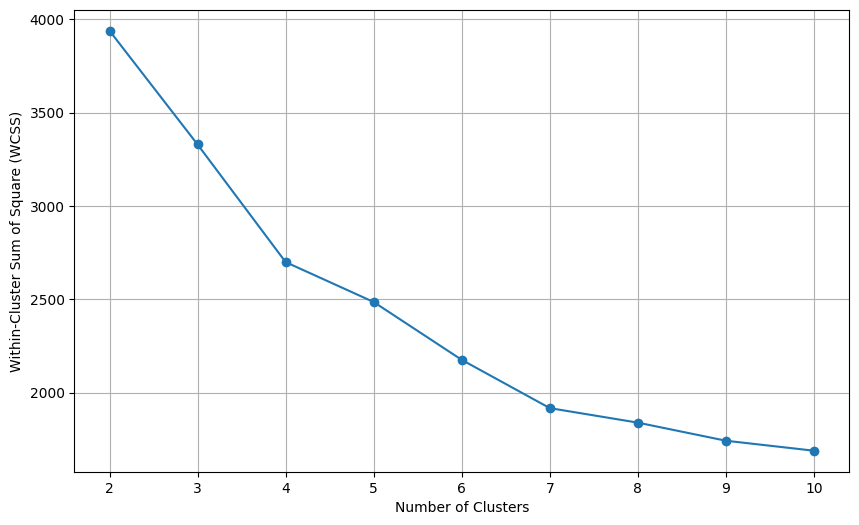

In [23]:
# Range of clusters to try
range_of_clusters = range(2, 11)  # For example, from 1 to 10

# List to store the values of Within-Cluster Sum of Square (WCSS)
wcss = []

for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(kmeans_dataset)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph
plt.figure(figsize=(10, 6))
plt.plot(range_of_clusters, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Square (WCSS)')
plt.grid(True)
plt.show()

In [24]:
# Define qty of clusters
k = optimal_k

# Apply k-means
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_dataset['cluster'] = kmeans.fit_predict(kmeans_dataset)

# # Adjusting cluster labels 0:k-1 to 1:k
# adjusted_cluster_labels = cluster_labels + 1

# # Add the adjusted cluster labels to dataset
# auburn_df['cluster'] = adjusted_cluster_labels

# Analyze results
cluster_centers = pd.DataFrame(kmeans.cluster_centers_)
cluster_centers['cluster'] = range(1,k+1)
print(cluster_centers)

          0         1         2         3         4  cluster
0  0.071007  0.156884  0.417289 -0.261128  1.863127        1
1 -0.436384 -0.552872 -0.562301 -0.399026 -0.306058        2
2 -0.521186 -0.249814 -0.044506  2.675216 -0.396687        3
3  1.036217  1.138001  0.939608  0.088148 -0.305565        4


Now interpret the clsuter centroids by scaling the values back to original scale.

In [25]:
# Get the centroids of the clusters in the scaled space
scaled_centroids = kmeans.cluster_centers_

# Convert the centroids back to the original scale
original_centroids = scaler.inverse_transform(scaled_centroids)

# Create a DataFrame for easier interpretation
original_centroids_df = pd.DataFrame(original_centroids, columns=scaled_auburn_df.columns)  # use the column names from the original dataset

# Display the centroids in the original scale
print(original_centroids_df)

       beds     baths          price      area  trailhead_score
0  3.267081  2.512422  709672.670807  0.273808         2.978638
1  2.872414  1.946552  515413.620690  0.239220         0.977168
2  2.806452  2.188172  618095.698925  1.010330         0.893546
3  4.017857  3.294643  813251.785714  0.361417         0.977623


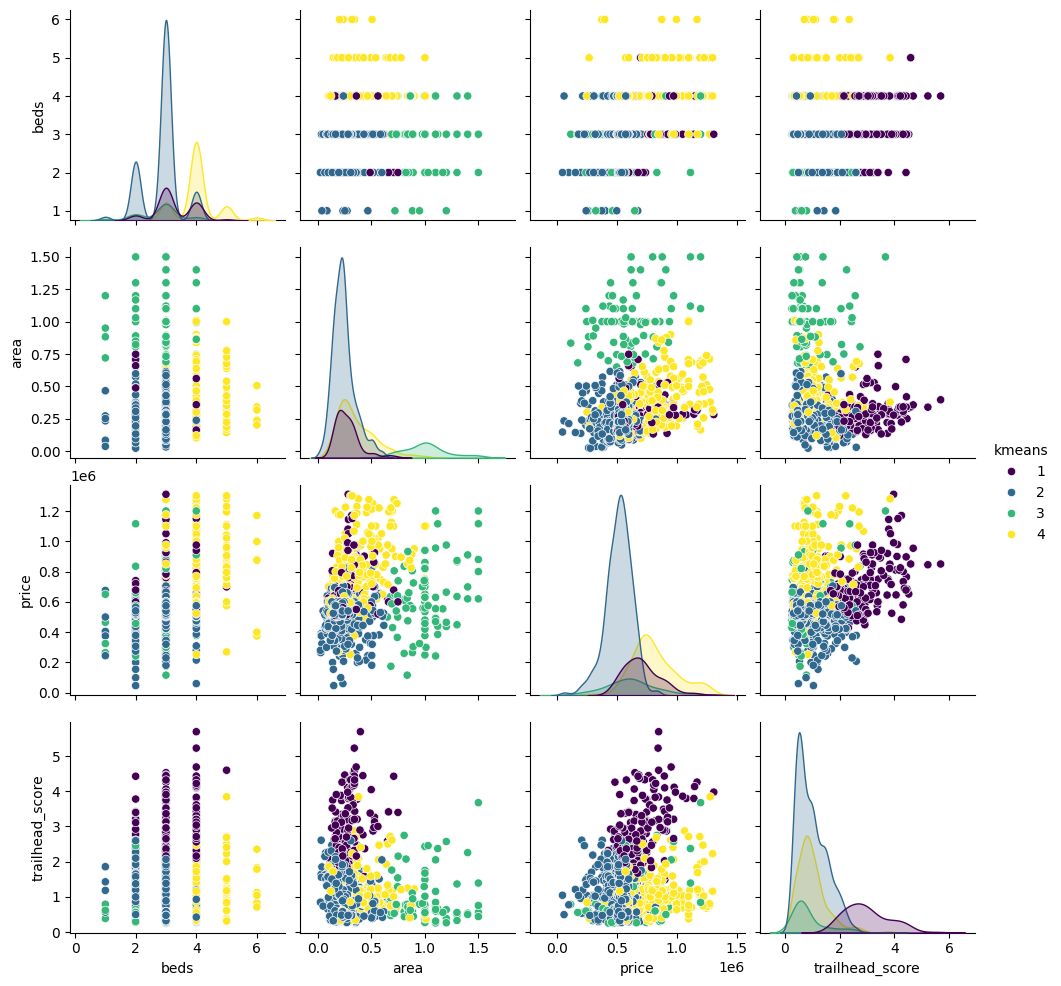

In [26]:
# Add the cluster labels to the original dataset
auburn_df['kmeans'] = kmeans.labels_
auburn_df['kmeans'] += 1

# Selecting a subset of columns for the pair plot to avoid too many plots
subset_columns = ['beds','area','price', 'trailhead_score','kmeans']
pairplot_data = auburn_df[subset_columns]

# Create the pair plot
sns.pairplot(pairplot_data, hue='kmeans', palette='viridis')
plt.savefig('./cluster_plots/kmeans_trailhead_pairplot.png')
plt.show()


In [27]:
def plot_indv_clusters(x, y, cluster_type, data):
    # Get unique clusters and the number of clusters, sorted for consistency
    clusters = sorted(data[cluster_type].unique())

    # Generate colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))
    color_dict = {cluster: color for cluster, color in zip(clusters, colors)}

    for cluster in clusters:
        clustered_data = data[data[cluster_type] == cluster]
        color = color_dict[cluster]

        plt.figure(figsize=(6, 6))
        plt.scatter(clustered_data[x], clustered_data[y], alpha=1, color=color)

        # Linear regression and plot the trend line
        x_values = clustered_data[x]
        y_values = clustered_data[y]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
        r2 = r_value ** 2
        plt.plot(x_values, intercept + slope * x_values, 'r')
        plt.text(0.75, 0.95, f"$R^2 = {r2:.2f}$", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
                 bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.6))

        plt.title(f'{cluster_type} cluster {cluster}')
        plt.xlabel(x)
        plt.ylabel(y)
        plt.savefig(f'./cluster_plots/{cluster_type}_{x}_{cluster}.png')
        plt.show()

    return color_dict


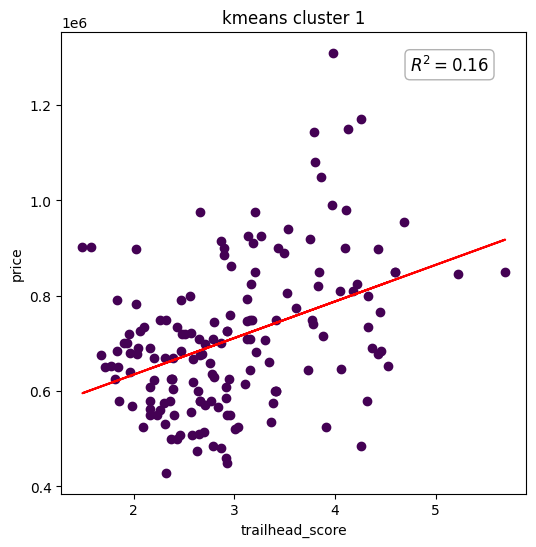

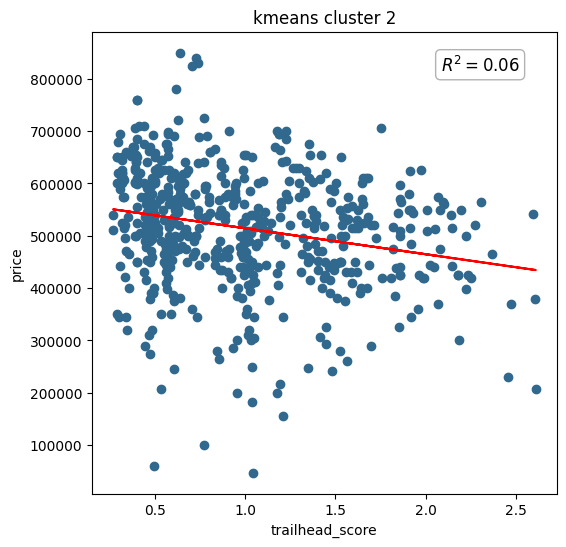

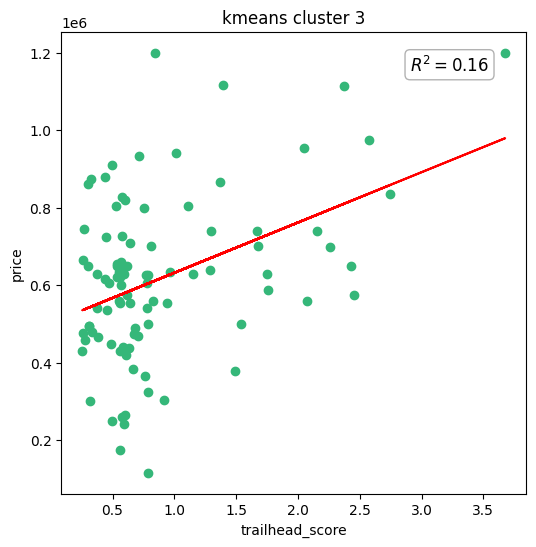

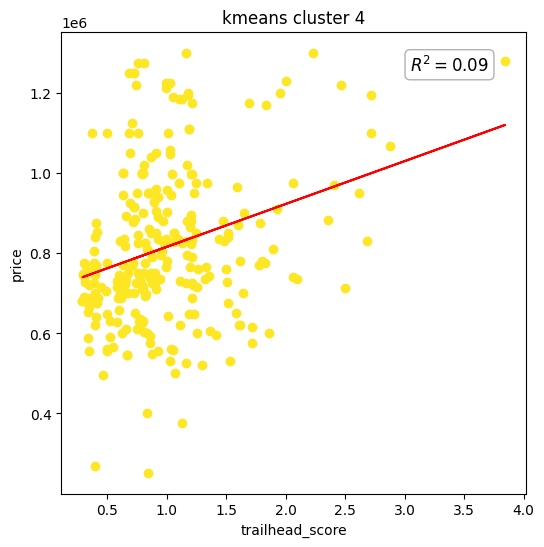

In [28]:
color_dict = plot_indv_clusters(x = 'trailhead_score', y = 'price', cluster_type = 'kmeans', data = auburn_df)

### Hypothesis Testing - kmeans Clusters
First, model sales price with multiple linear regression

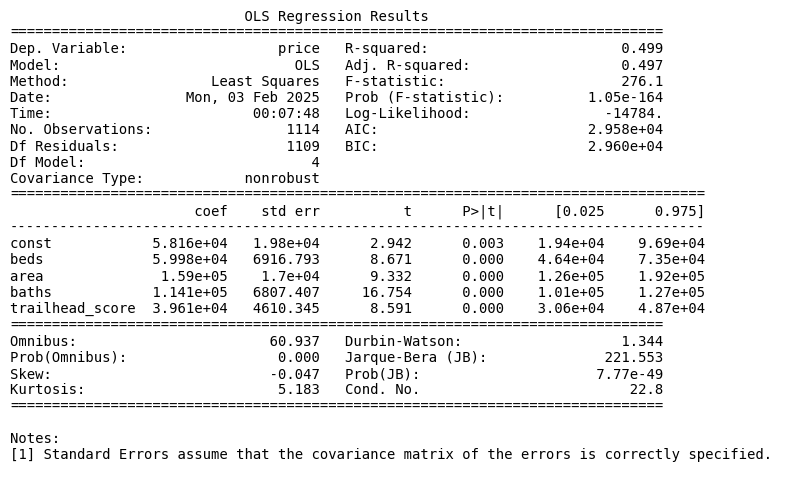

In [29]:
X = auburn_df[['beds', 'area','baths', 'trailhead_score']]
y = auburn_df['price']
X = sm.add_constant(X)

model = sm.OLS(y,X).fit()
# print(model.summary())
summary_text = model.summary().as_text()

# Convert summary text into an image
fig, ax = plt.subplots(figsize=(10, 6))
ax.text(0, 1, summary_text, fontsize=10, family="monospace", verticalalignment='top')
ax.axis('off')

plt.savefig("./hypo_tests/OLS_trailhead_full_mod.png", dpi=300, bbox_inches='tight')
plt.show()

Test whether segmentated clusters can be modeled with linear regression

In [30]:
shapiro_sig = 0.01

for cluster in sorted(auburn_df['kmeans'].unique()):
    cluster_data = auburn_df[auburn_df['kmeans'] == cluster]
    X = cluster_data[['trailhead_score']]
    y = cluster_data['price']
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    summary_text = model.summary().as_text()  # Convert summary to text

    # Create Matplotlib figure for the summary
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.text(0, 1, summary_text, fontsize=10, family="monospace", verticalalignment='top')
    ax.axis('off')  # Hide axes

    # Save the summary as an image
    save_path = f"./hypo_tests/kmeans_trailhead_OLS_cluster_{cluster}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # plt.show()
    plt.close(fig)


    residuals = model.resid
    shapiro_test = shapiro(residuals)
    if shapiro_test.pvalue > shapiro_sig:
      print(f"Cluster {cluster}:\n", model.summary(),"\n")
      print("The residuals are normally distributed.")
      print(f"Shapiro-Wilk Test: p-value = {shapiro_test.pvalue}\n")

Cluster 3:
                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     17.95
Date:                Mon, 03 Feb 2025   Prob (F-statistic):           5.43e-05
Time:                        00:07:55   Log-Likelihood:                -1264.5
No. Observations:                  93   AIC:                             2533.
Df Residuals:                      91   BIC:                             2538.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.022e+05   3

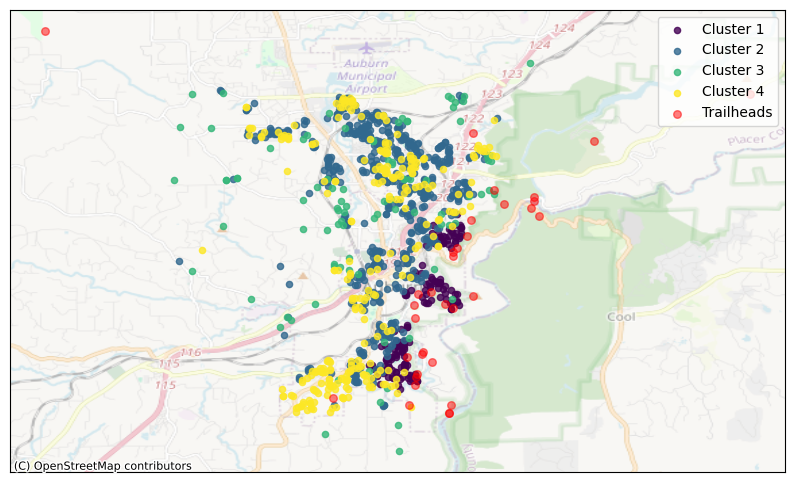

In [31]:
# Convert 'auburn_df' to GeoDataFrame and project it
auburn_gdf = gpd.GeoDataFrame(
    auburn_df,
    geometry=[Point(xy) for xy in zip(auburn_df['lon'], auburn_df['lat'])],
    crs="EPSG:4326"
)
auburn_gdf = auburn_gdf.to_crs(epsg=3857)

# Convert 'trailhead_df' to GeoDataFrame and project it
trailhead_gdf = gpd.GeoDataFrame(
    trailhead_df,
    geometry=[Point(xy) for xy in zip(trailhead_df['Longitude'], trailhead_df['Latitude'])],
    crs="EPSG:4326"
)
trailhead_gdf = trailhead_gdf.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot clusters
clusters = sorted(auburn_gdf['kmeans'].unique())
for cluster in clusters:
    color = color_dict[cluster]
    subset = auburn_gdf[auburn_gdf['kmeans'] == cluster]
    ax.scatter(subset.geometry.x, subset.geometry.y, color=color, label=f"Cluster {cluster}", s=20, alpha=0.8)

# Plot trailheads
ax.scatter(trailhead_gdf.geometry.x, trailhead_gdf.geometry.y, color='red', label='Trailheads', s=30, alpha=0.5)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12, alpha=0.5)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')  # Hide X-axis label
ax.set_ylabel('')  # Hide Y-axis label

# ax.set_title("Mapped Clusters and Trailheads")

plt.legend(loc="upper right")
save_path = f"./cluster_mapping/kmeans_cluster_mapping_trailhead.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# EM Clustering

Again, let's determine the optimal quantity of clusters using the solhoutte score.

In [32]:
# EM_dataset = scaled_auburn_df.copy()
# print(EM_dataset.info())
# range_of_clusters = range(2, 10)

# silhouette_scores = {}

# for k in range_of_clusters:
#     gmm = GaussianMixture(n_components=k, random_state=42)

#     # Fit the clustering model and assign each point to the cluster with the highest probability
#     cluster_labels = gmm.fit_predict(EM_dataset)

#     score = silhouette_score(EM_dataset, cluster_labels)
#     silhouette_scores[k] = score
#     # print(f'Silhouette Score for {k} clusters: {score}')

# # Find the optimal number of clusters based on silhouette score
# optimal_k = max(silhouette_scores, key=silhouette_scores.get)
# # print(f'Optimal number of clusters: {optimal_k}')

# # Visualize silhouette scores
# plt.figure(figsize=(8, 5))
# plt.plot(range_of_clusters, silhouette_scores.values(), marker='o')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Scores for EM Clustering')
# plt.show()

In [33]:
# # Now perform clustering with the optimal number of clusters
# k = optimal_k

# # Apply EM clustering using Gaussian Mixture Model
# gmm = GaussianMixture(n_components=k, random_state=42)
# gmm_labels = gmm.fit_predict(EM_dataset)

# gmm_labels_adjusted = gmm_labels + 1

# # Add the GMM cluster labels to your original dataset
# auburn_df = auburn_df.drop(columns=['EM'], errors='ignore')  # Drop 'EM' if it exists
# auburn_df['EM'] = gmm_labels_adjusted


# # Visualize with similar pair plot
# pairplot_data_gmm = auburn_df[['beds', 'area', 'price', 'trailhead_score','EM']]
# sns.pairplot(pairplot_data_gmm, hue='EM', palette='viridis')
# plt.savefig('/content/drive/MyDrive/DTSA 5510 - UL/Project/cluster_plots/em_pairplot.png')
# plt.show()


In [34]:
# plot_indv_clusters(x = 'trailhead_score', y = 'price', cluster_type = 'EM', data = auburn_df)

# Heirarchical Clustering

### Determine optimal number of clusters using silhouette score

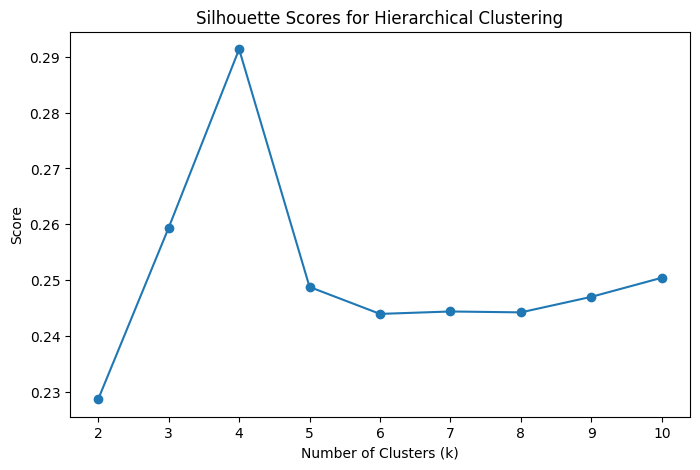

In [35]:
# Set up the clustering model
heir_dataset = scaled_auburn_df.copy()
range_of_clusters = range(2, 11)

silhouette_scores = {}
wcss_values = {}

for k in range_of_clusters:
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    cluster_labels = agg_clustering.fit_predict(heir_dataset)

    silhouette_scores[k] = silhouette_score(heir_dataset, cluster_labels)


optimal_k = max(silhouette_scores, key=silhouette_scores.get)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range_of_clusters, silhouette_scores.values(), marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.title('Silhouette Scores for Hierarchical Clustering')
plt.savefig('./score_plots/heir_trailhead_silhouette.png')
plt.show()


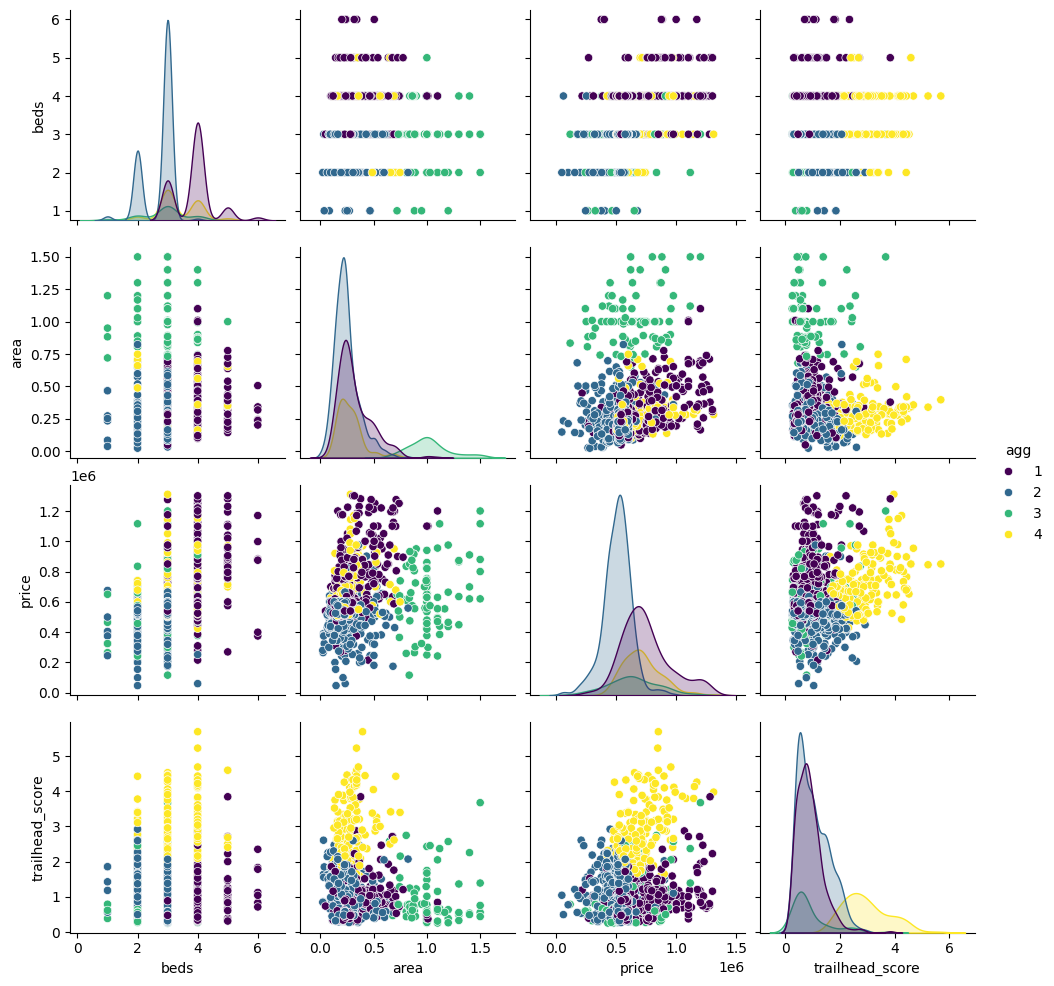

In [36]:
agg_clustering = AgglomerativeClustering(n_clusters = optimal_k,
                                         linkage = 'ward',
                                         metric = 'euclidean')

#fit the model
agg_clustering.fit(heir_dataset)
agg_labels = agg_clustering.labels_+1
heir_dataset['agg_cluster'] = agg_labels
auburn_df['agg'] = agg_labels

# Visualize with similar pair plot
pairplot_data_gmm = auburn_df[['beds', 'area', 'price', 'trailhead_score','agg']]
sns.pairplot(pairplot_data_gmm, hue='agg', palette='viridis')
plt.savefig('./cluster_plots/agg_trailhead_pairplot.png')
plt.show()


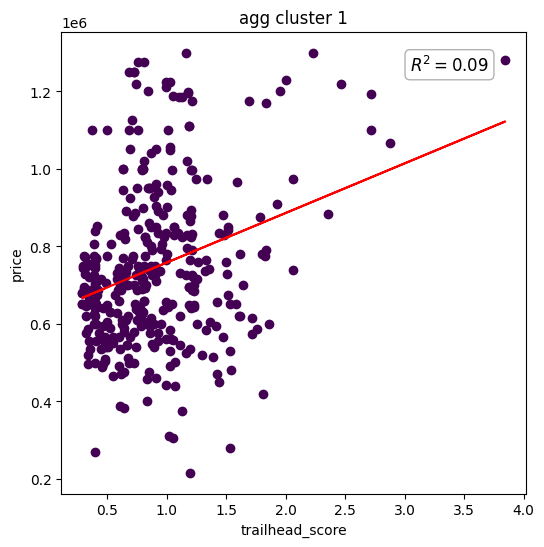

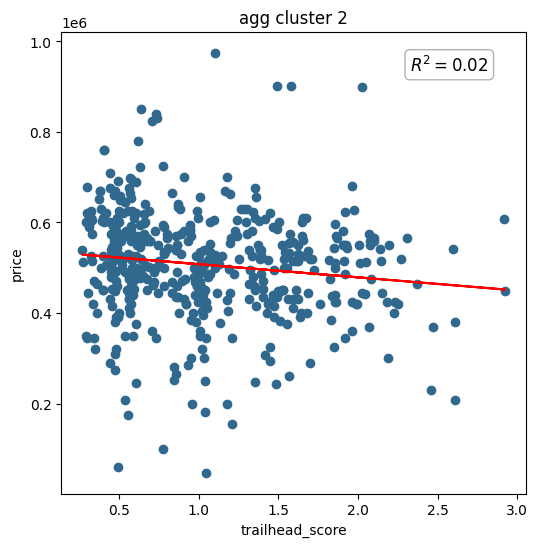

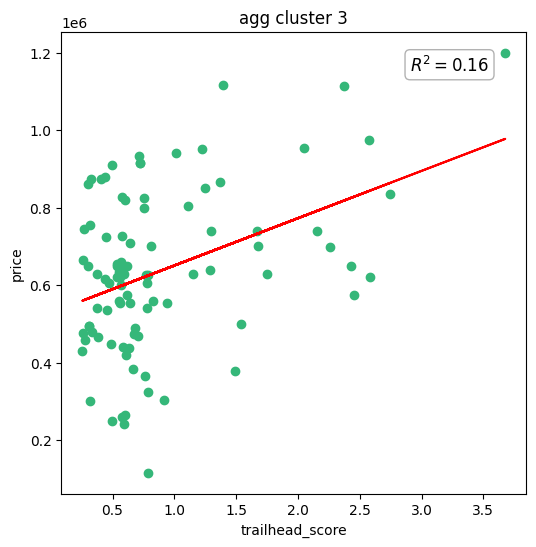

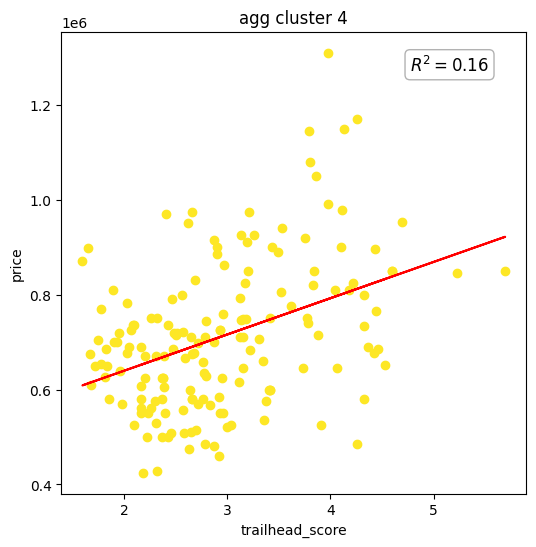

In [37]:
color_dict = plot_indv_clusters(x = 'trailhead_score', y = 'price', cluster_type = 'agg', data = auburn_df)

### Hypothesis Testing - Heirarchical Clusters


Test whether segmentated clusters can be modeled with linear regression

In [38]:
for cluster in sorted(auburn_df['agg'].unique()):
    cluster_data = auburn_df[auburn_df['agg'] == cluster]
    X = cluster_data[['trailhead_score']]
    y = cluster_data['price']
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    summary_text = model.summary().as_text()  # Convert summary to text

    # Create Matplotlib figure for the summary
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.text(0, 1, summary_text, fontsize=10, family="monospace", verticalalignment='top')
    ax.axis('off')  # Hide axes

    # Save the summary as an image
    save_path = f"./hypo_tests/OLS_agg_trailhead_cluster_{cluster}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # plt.show()
    plt.close(fig)


    residuals = model.resid
    shapiro_test = shapiro(residuals)
    if shapiro_test.pvalue > shapiro_sig:
      print(f"Cluster {cluster}:\n", model.summary(),"\n")
      print("The residuals are normally distributed.")
      print(f"Shapiro-Wilk Test: p-value = {shapiro_test.pvalue}\n")

Cluster 3:
                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     16.99
Date:                Mon, 03 Feb 2025   Prob (F-statistic):           8.28e-05
Time:                        00:08:11   Log-Likelihood:                -1262.7
No. Observations:                  93   AIC:                             2529.
Df Residuals:                      91   BIC:                             2534.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.286e+05   3

### Plot Clusters on a Map

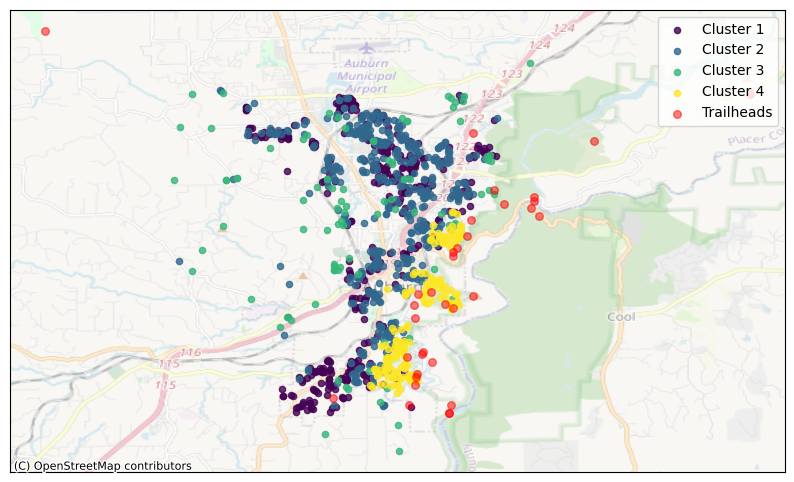

In [39]:
# Convert 'auburn_df' to GeoDataFrame and project it
auburn_gdf = gpd.GeoDataFrame(
    auburn_df,
    geometry=[Point(xy) for xy in zip(auburn_df['lon'], auburn_df['lat'])],
    crs="EPSG:4326"
)
auburn_gdf = auburn_gdf.to_crs(epsg=3857)

# Convert 'trailhead_df' to GeoDataFrame and project it
trailhead_gdf = gpd.GeoDataFrame(
    trailhead_df,
    geometry=[Point(xy) for xy in zip(trailhead_df['Longitude'], trailhead_df['Latitude'])],
    crs="EPSG:4326"
)
trailhead_gdf = trailhead_gdf.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot clusters
clusters = sorted(auburn_gdf['agg'].unique())
for cluster in clusters:
    color = color_dict[cluster]
    subset = auburn_gdf[auburn_gdf['agg'] == cluster]
    ax.scatter(subset.geometry.x, subset.geometry.y, color=color, label=f"Cluster {cluster}", s=20, alpha=0.8)

# Plot trailheads
ax.scatter(trailhead_gdf.geometry.x, trailhead_gdf.geometry.y, color='red', label='Trailheads', s=30, alpha=0.5)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12, alpha=0.5)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')  # Hide X-axis label
ax.set_ylabel('')  # Hide Y-axis label

# ax.set_title("Mapped Clusters and Trailheads")

plt.legend(loc="upper right")
save_path = f"./cluster_mapping/agg_cluster_mapping_trailhead.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# Clustering with Heatmap Data

A significant challenge in incorporating trailhead locations as a feature in spatial analyses is the lack of publicly available, standardized datasets. The trailhead dataset utilized in this study is derived primarily from personal knowledge and experience, rather than a structured database. Moreover, trailhead locations, as defined in this analysis, refer to commonly used points of access to trails, rather than officially designated trailheads, further complicating data acquisition. This approach, while intuitive and contextually relevant, is not easily scalable, limiting its applicability across broader geographic regions.

As a scalable alternative, GPS data from fitness tracking applications can provide a robust and automated method for quantifying not only trail accessibility but also general outdoor recreation activity. This study employs personal GPS activity data as a proof of concept to explore the feasibility of using heatmap-based clustering for recreation accessibility modeling.

The dataset was exported from Strava, containing .gpx and .fit files recorded via GPS-enabled running watches, bike computers, and mobile phones. The dataset includes approximately 1,300 activities, capturing detailed spatial movement patterns associated with outdoor recreational activities. This approach demonstrates a scalable method for quantifying recreational access without relying on predefined or manually curated trailhead locations.

#### Feature Engineering Recreation Score

In [40]:
#First, we need to start with the original real estate data and re-scale the data with the new feature
auburn_df_rec = auburn_df.copy()
auburn_df_rec.drop(['kmeans','agg','trailhead_score'], axis = 1, inplace = True)
print(auburn_df_rec.head())

# Drop the lat-long data. We aren't using it to cluster at this point
temp = auburn_df_rec.drop(['lat','lon'], axis = 1)

# Convert auburn_df to a GeoDataFrame with EPSG:4326 (lat/lon)
auburn_df_rec = gpd.GeoDataFrame(auburn_df_rec, geometry=gpd.points_from_xy(auburn_df.lon, auburn_df.lat), crs="EPSG:4326")

   beds  baths        lat         lon     price      area
0   3.0    3.0  38.922077 -121.073715  700000.0  0.315404
1   5.0    3.0  38.868380 -121.093650  790000.0  0.439509
2   4.0    2.0  38.926178 -121.049740  865000.0  1.300000
5   3.0    2.0  38.890656 -121.065930  652000.0  0.332600
6   3.0    2.0  38.932790 -121.104294  610000.0  0.198806


In [41]:
# Read in the density grid
path = './strava_heatmaps/grid_10.csv'

grid = pd.read_csv(path)

grid['geometry'] = grid['geometry'].apply(loads)

#convert to Geodataframe
grid = gpd.GeoDataFrame(grid, geometry='geometry',crs="EPSG:4326")
grid.head()


geometry  density  \
0  POLYGON ((-121.22 38.82, -121.20981 38.82, -12...    998.0   
1  POLYGON ((-121.22 38.83019, -121.20981 38.8301...    489.0   
2  POLYGON ((-121.22 38.84038, -121.20981 38.8403...      0.0   
3  POLYGON ((-121.22 38.85057, -121.20981 38.8505...    486.0   
4  POLYGON ((-121.22 38.86076, -121.20981 38.8607...    246.0   

   density_normalized  
0            0.009122  
1            0.004470  
2            0.000000  
3            0.004442  
4            0.002249

In [42]:
# Reproject both dfs to the same projected CRS (EPSG:3310 - California Albers)
grid = grid.to_crs(epsg=3310)
auburn_df_rec = auburn_df_rec.to_crs(epsg=3310)  # Now in meters

# Convert grid centroids to numpy array for efficient searching
grid['centroid'] = grid.geometry.centroid
grid_points = np.array([(point.x, point.y) for point in grid['centroid']])
grid_tree = KDTree(grid_points)  # KDTree for fast spatial lookup

# Define radius in kilometers
radius_km = 10
radius_m = radius_km*1000
radius_deg = radius_km / 111.32  # Convert km to degrees

# Compute recreation scores
for index, row in auburn_df_rec.iterrows():
    prop_x, prop_y = row.geometry.x, row.geometry.y
    # print(prop_lat,prop_lon)

    # Find grid cells within the radius
    nearby_idxs = grid_tree.query_ball_point([prop_x, prop_y], radius_m)
    # print(nearby_idxs)

    # Sum up density values for recreation score
    recreation_score = grid.iloc[nearby_idxs]['density'].sum()

    #Optionally apply weighted sum by distance
    if nearby_idxs:
        distances = [euclidean((prop_x, prop_y), (grid.iloc[i].centroid.x, grid.iloc[i].centroid.y)) + 1e-6 for i in nearby_idxs]
        recreation_score_weighted = sum(grid.iloc[i]['density'] / (d**2) for i, d in zip(nearby_idxs, distances) if d > 0)
    else:
        recreation_score_weighted = 0

    # Store in DataFrame
    auburn_df_rec.at[index, 'rec_score'] = recreation_score
    auburn_df_rec.at[index, 'rec_score_wt'] = recreation_score_weighted

auburn_df_rec.to_csv('./rec_score.csv', index = False)

In [43]:
# auburn_df_rec = pd.read_csv('./rec_score.csv')
auburn_df_rec.head()

beds  baths        lat         lon     price      area  \
0   3.0    3.0  38.922077 -121.073715  700000.0  0.315404   
1   5.0    3.0  38.868380 -121.093650  790000.0  0.439509   
2   4.0    2.0  38.926178 -121.049740  865000.0  1.300000   
5   3.0    2.0  38.890656 -121.065930  652000.0  0.332600   
6   3.0    2.0  38.932790 -121.104294  610000.0  0.198806   

                        geometry  rec_score  rec_score_wt  
0  POINT (-92999.868 101205.181)  1068387.0      0.117009  
1   POINT (-94795.309 95256.956)   962259.0      0.094548  
2  POINT (-90918.312 101637.715)  1100317.0      0.708247  
5   POINT (-92364.863 97705.398)  1047530.0      0.448673  
6  POINT (-95634.483 102426.248)  1020712.0      0.033174

In [44]:
Q1 = auburn_df_rec['rec_score_wt'].quantile(0.25)
Q3 = auburn_df_rec['rec_score_wt'].quantile(0.75)
IQR = Q3 - Q1
coef = 5  # Multiplier for outlier range

# Define a mask for values within the IQR range
mask = (auburn_df_rec['rec_score_wt'] >= (Q1 - coef * IQR)) & (auburn_df_rec['rec_score_wt'] <= (Q3 + coef * IQR))

# Apply the mask to filter the DataFrame
auburn_df_filtered = auburn_df_rec[mask]

print(f"Original DataFrame size: {auburn_df_rec.shape[0]}")
print(f"New DataFrame size after outlier removal: {auburn_df_filtered.shape[0]}")

# Update auburn_df_rec with the filtered DataFrame
auburn_df_rec = auburn_df_filtered


Original DataFrame size: 1114
New DataFrame size after outlier removal: 1070


In [45]:
auburn_df_rec.drop(['geometry','rec_score'], axis = 1, inplace = True)
auburn_df_rec.head()


<ipython-input-45-e2968721dc37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auburn_df_rec.drop(['geometry','rec_score'], axis = 1, inplace = True)


beds  baths        lat         lon     price      area  rec_score_wt
0   3.0    3.0  38.922077 -121.073715  700000.0  0.315404      0.117009
1   5.0    3.0  38.868380 -121.093650  790000.0  0.439509      0.094548
2   4.0    2.0  38.926178 -121.049740  865000.0  1.300000      0.708247
5   3.0    2.0  38.890656 -121.065930  652000.0  0.332600      0.448673
6   3.0    2.0  38.932790 -121.104294  610000.0  0.198806      0.033174

In [46]:
# Create a StandardScaler object
scaler = StandardScaler()

# Apply the scaler to the entire DataFrame
scaled_data = scaler.fit_transform(auburn_df_rec.drop(['lat','lon'], axis = 1))

# The result is a NumPy array. Convert it back to a DataFrame with the same column names
scaled_rec_df = pd.DataFrame(scaled_data, columns=auburn_df_rec.drop(['lat','lon'], axis = 1).columns)

# Display the first few rows of the scaled DataFrame
scaled_rec_df.head(5)

beds     baths     price      area  rec_score_wt
0 -0.282588  0.772513  0.376887 -0.107645     -0.489156
1  2.301765  0.772513  0.833027  0.384336     -0.569889
2  1.009588 -0.486572  1.213145  3.795530      1.635952
3 -0.282588 -0.486572  0.133611 -0.039476      0.702957
4 -0.282588 -0.486572 -0.079254 -0.569867     -0.790487

## k-Means Clustering

Optimal number of clusters: 3


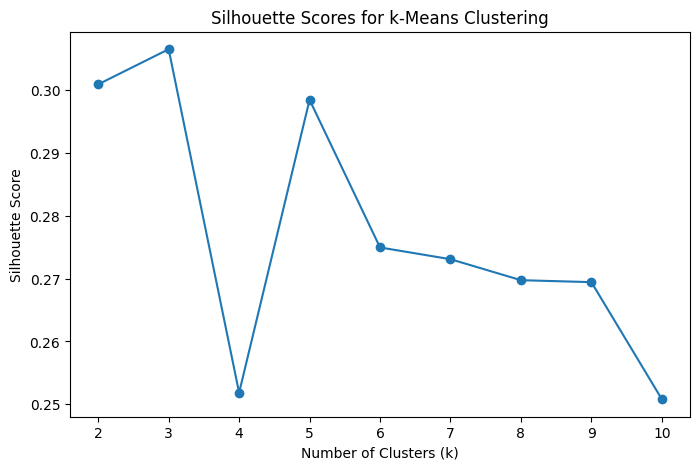

In [47]:
# Load dataset
kmeans_dataset = scaled_rec_df.copy()

# Range of potential clusters to evaluate
range_of_clusters = range(2, 11)

# Dictionary to hold the silhouette scores for each k
silhouette_scores = {}

for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(kmeans_dataset)

    # Silhouette score
    score = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores[k] = score
    # print(f'Silhouette Score for {k} clusters: {score}')

# Find the optimal number of clusters based on silhouette score
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f'Optimal number of clusters: {optimal_k}')


# Visualize silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range_of_clusters, silhouette_scores.values(), marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for k-Means Clustering')
plot_path = './score_plots/kmeans_rec_sil.png'
plt.savefig(plot_path)

plt.show()

#save plot

In [48]:
# Define qty of clusters
k = optimal_k

# Apply k-means
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_dataset['cluster'] = kmeans.fit_predict(kmeans_dataset)

# # Adjusting cluster labels 0:k-1 to 1:k
# adjusted_cluster_labels = cluster_labels + 1

# # Add the adjusted cluster labels to dataset
# auburn_df['cluster'] = adjusted_cluster_labels

# Analyze results
# cluster_centers = pd.DataFrame(kmeans.cluster_centers_)
# cluster_centers['cluster'] = range(1,k+1)
# print(cluster_centers)

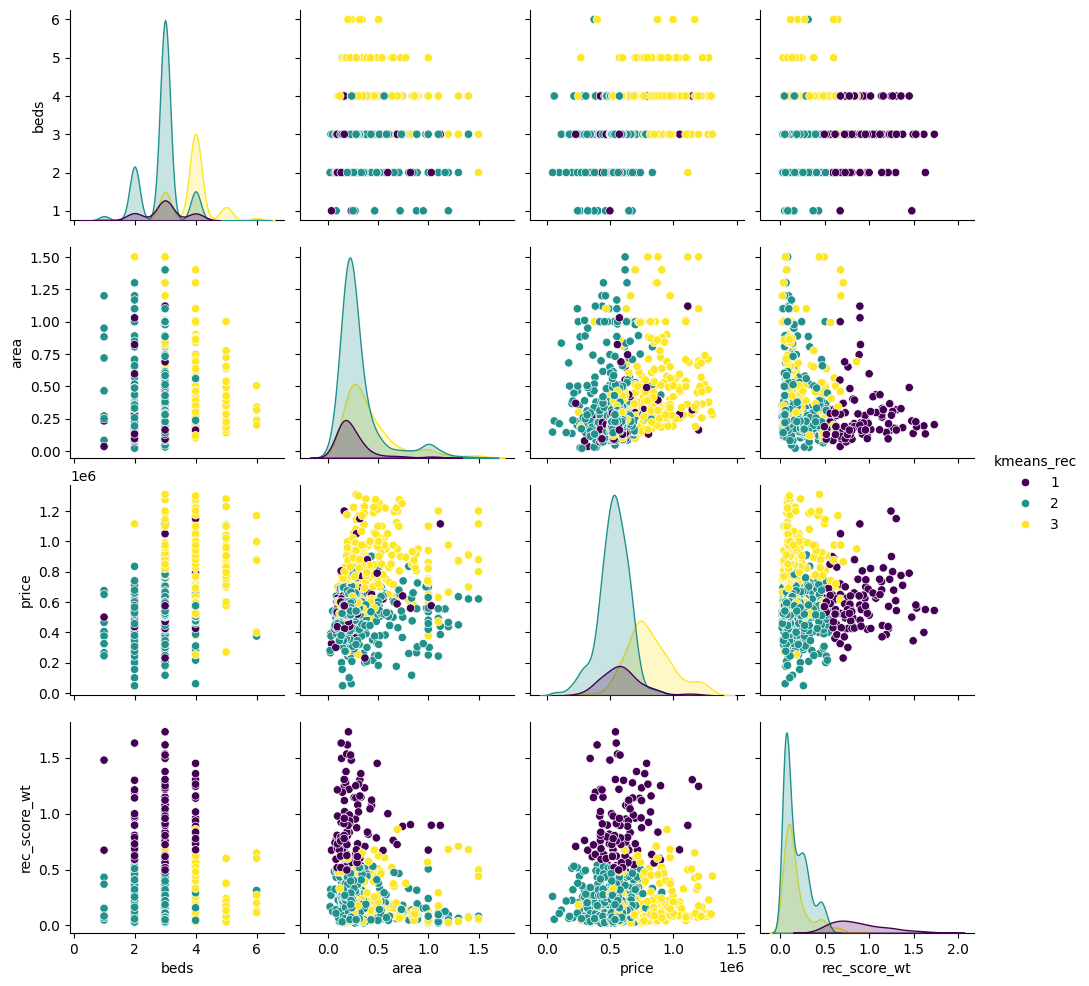

In [49]:
# Add the cluster labels to the original dataset
auburn_df_rec['kmeans_rec'] = kmeans.labels_
auburn_df_rec['kmeans_rec'] += 1

# Selecting a subset of columns for the pair plot to avoid too many plots
subset_columns = ['beds','area','price', 'rec_score_wt','kmeans_rec']
pairplot_data = auburn_df_rec[subset_columns]

# Create the pair plot
sns.pairplot(pairplot_data, hue='kmeans_rec', palette='viridis')
plt.savefig('./cluster_plots/kmeans_rec_pairplot.png')
plt.show()


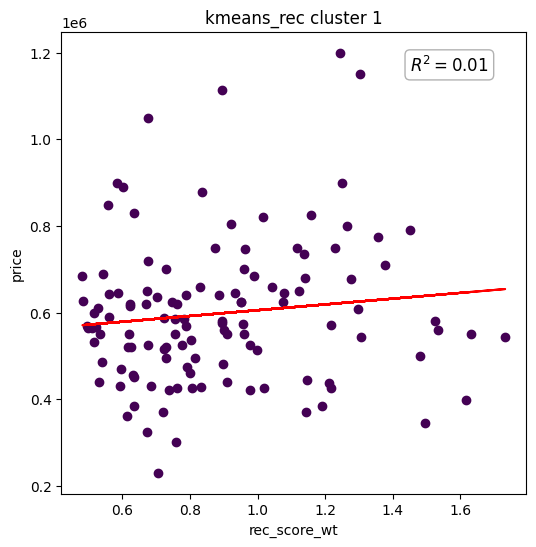

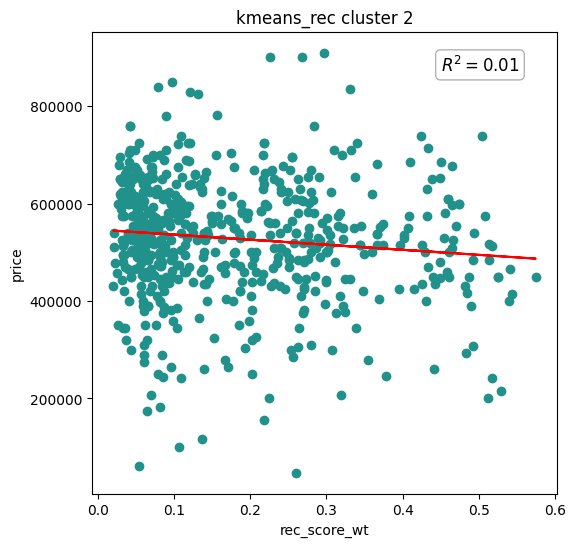

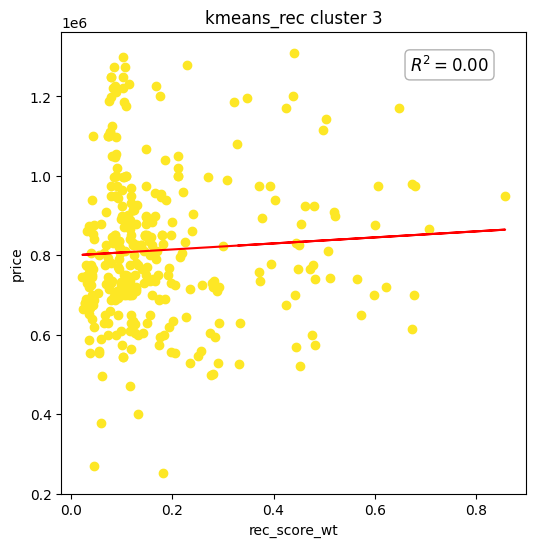

{1: array([0.267004, 0.004874, 0.329415, 1.      ]),
 2: array([0.127568, 0.566949, 0.550556, 1.      ]),
 3: array([0.993248, 0.906157, 0.143936, 1.      ])}

In [50]:
plot_indv_clusters(x = 'rec_score_wt', y = 'price', cluster_type = 'kmeans_rec', data = auburn_df_rec)

In [51]:
for cluster in sorted(auburn_df_rec['kmeans_rec'].unique()):
  cluster_data = auburn_df_rec[auburn_df_rec['kmeans_rec'] == cluster]
  X = cluster_data[['rec_score_wt']]
  y = cluster_data['price']
  X = sm.add_constant(X)

  model = sm.OLS(y,X).fit()
  plt.savefig(f"./hypo_tests/OLS_kmeans_rec_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
  plt.show()

  residuals = model.resid
  shapiro_test = shapiro(residuals)
  if shapiro_test.pvalue > shapiro_sig:
    print(f"Cluster {cluster}:\n", model.summary(),"\n")
    print("The residuals are normally distributed.")
    print(f"Shapiro-Wilk Test: p-value = {shapiro_test.pvalue}\n")



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## Heirarchical Clustering

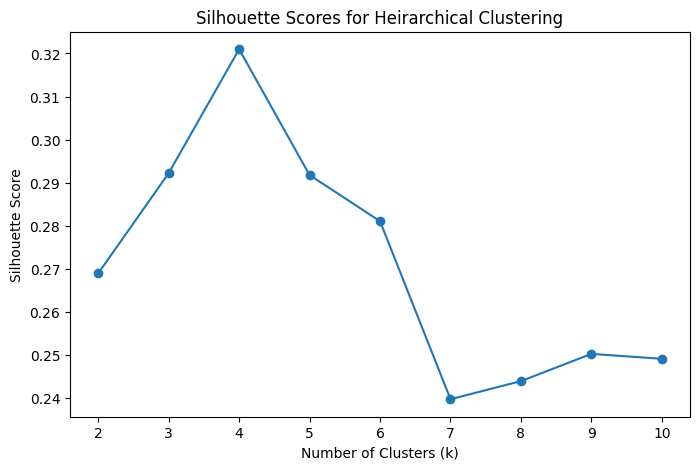

In [52]:
#set up the clustering model
heir_dataset = scaled_rec_df.copy()
range_of_clusters = range(2, 11)

silhouette_scores = {}

for k in range_of_clusters:
  agg_clustering = AgglomerativeClustering(n_clusters = k, linkage = 'ward',metric = 'euclidean')


  agg_clustering.fit(heir_dataset)
  cluster_labels = agg_clustering.labels_
  score = silhouette_score(heir_dataset, cluster_labels)
  silhouette_scores[k] = score
  # print(f'Silhouette Score for {k} clusters: {score}')

# Find the optimal number of clusters based on silhouette score
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
# print(f'Optimal number of clusters: {optimal_k}')

# Visualize silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range_of_clusters, silhouette_scores.values(), marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Heirarchical Clustering')
plt.savefig('./score_plots/agg_rec_sil.png')
plt.show()


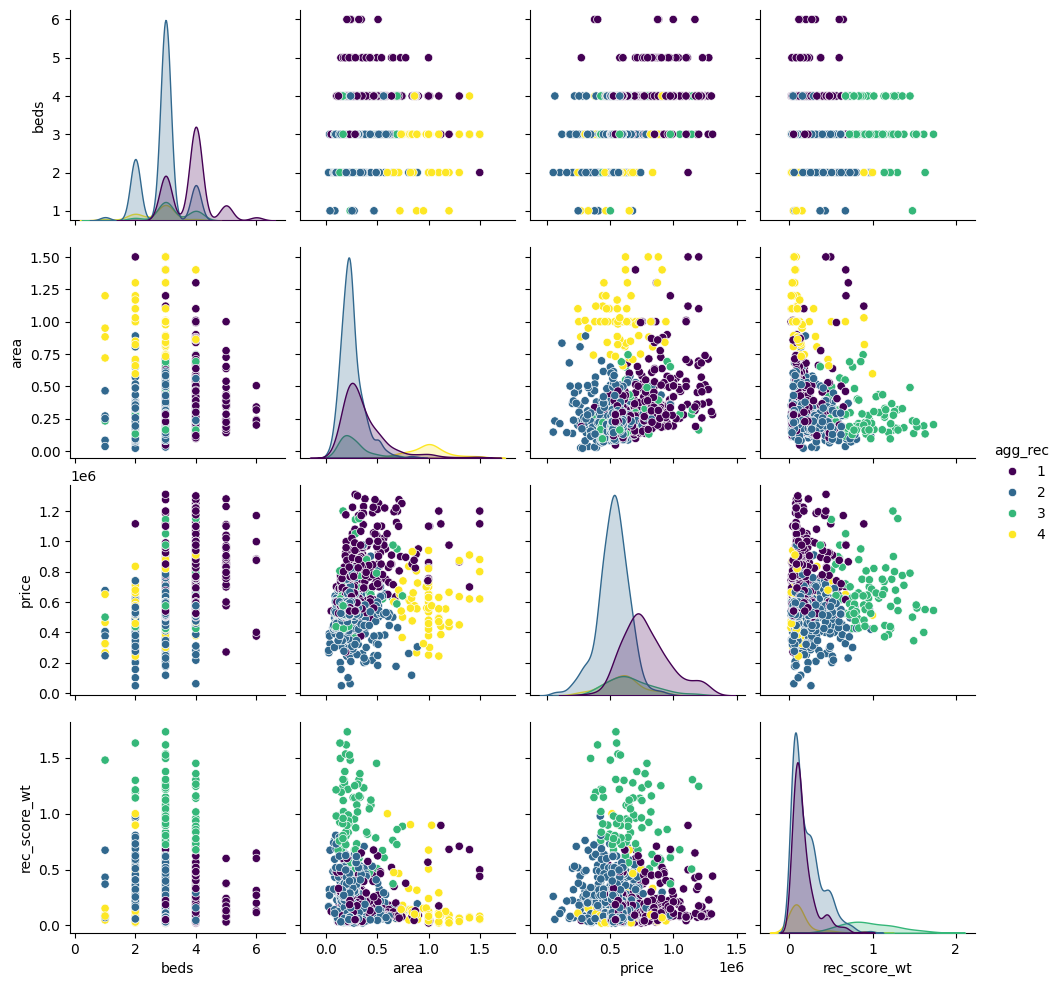

In [53]:
agg_clustering = AgglomerativeClustering(n_clusters = optimal_k,
                                         linkage = 'ward',
                                         metric = 'euclidean')

#fit the model
agg_clustering.fit(heir_dataset)
agg_labels = agg_clustering.labels_+1
heir_dataset['agg_cluster'] = agg_labels
auburn_df_rec['agg_rec'] = agg_labels

# Visualize with similar pair plot
pairplot_data_agg = auburn_df_rec[['beds', 'area', 'price', 'rec_score_wt','agg_rec']]
sns.pairplot(pairplot_data_agg, hue='agg_rec', palette='viridis')
plt.savefig('./cluster_plots/rec_agg_pairplot.png')
plt.show()


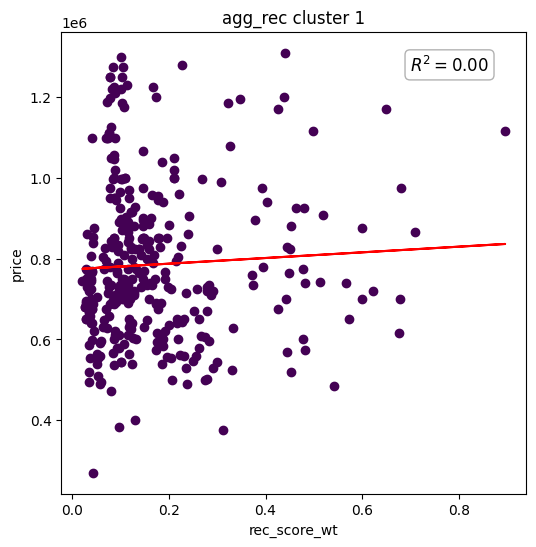

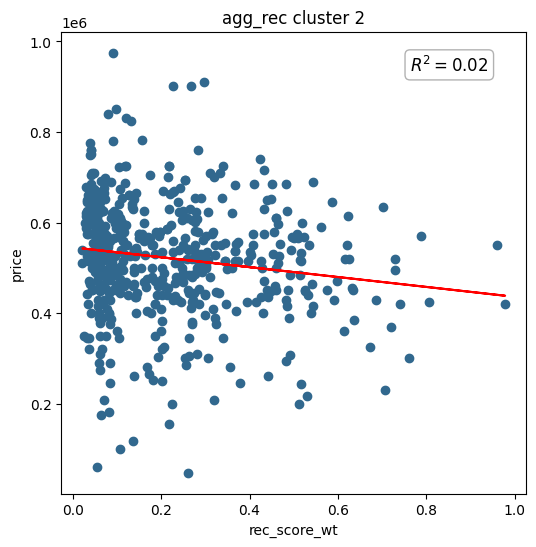

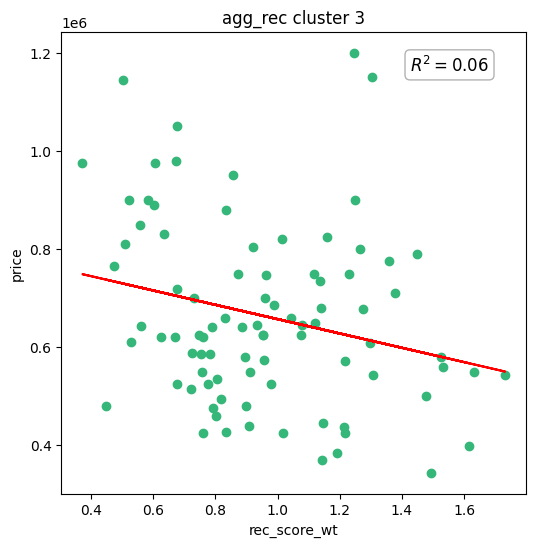

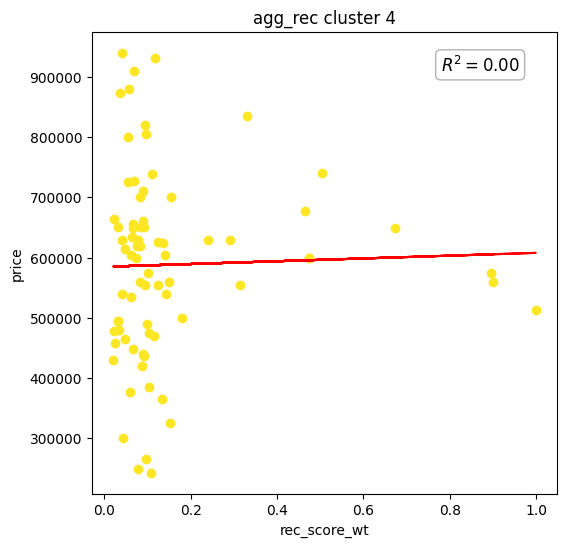

In [54]:
color_dict = plot_indv_clusters(x = 'rec_score_wt', y = 'price', cluster_type = 'agg_rec', data = auburn_df_rec)

In [55]:
for cluster in sorted(auburn_df_rec['agg_rec'].unique()):
  cluster_data = auburn_df_rec[auburn_df_rec['agg_rec'] == cluster]
  X = cluster_data[['rec_score_wt']]
  y = cluster_data['price']
  X = sm.add_constant(X)

  model = sm.OLS(y,X).fit()
  plt.savefig(f"./hypo_tests/OLS_agg_rec_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
  plt.show()

  residuals = model.resid
  shapiro_test = shapiro(residuals)
  if shapiro_test.pvalue > shapiro_sig:
    print(f"Cluster {cluster}:\n", model.summary())
    print("The residuals are normally distributed.")
    print(f"Shapiro-Wilk Test: p-value = {shapiro_test.pvalue}\n")

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Cluster 4:
                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                   0.06631
Date:                Mon, 03 Feb 2025   Prob (F-statistic):              0.798
Time:                        00:10:13   Log-Likelihood:                -1002.3
No. Observations:                  75   AIC:                             2009.
Df Residuals:                      73   BIC:                             2013.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.847e+05   2.28e+04  

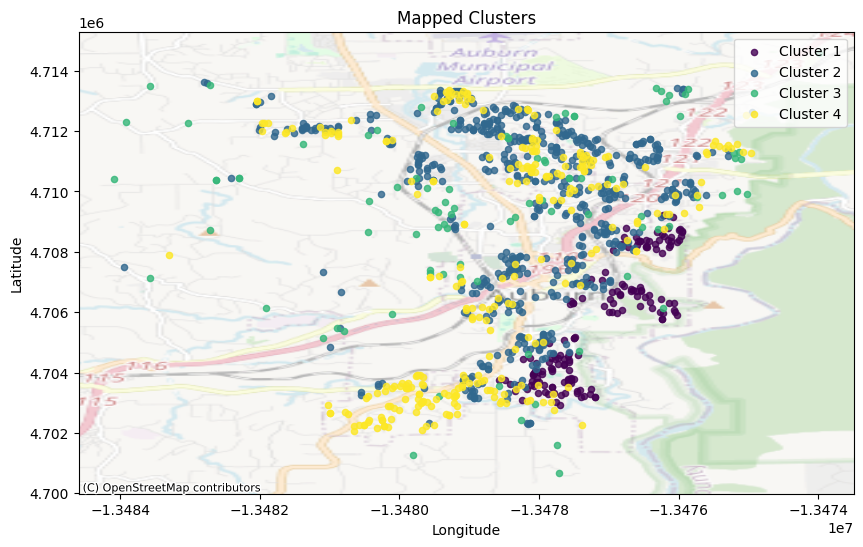

In [56]:
# Convert DataFrame to GeoDataFrame
auburn_gdf = gpd.GeoDataFrame(
    auburn_df,
    geometry=[Point(xy) for xy in zip(auburn_df['lon'], auburn_df['lat'])],
    crs="EPSG:4326"
)
auburn_gdf = auburn_gdf.to_crs(epsg=3857)

# Ensure that the colors are used consistently
fig, ax = plt.subplots(figsize=(10, 6))

for cluster in sorted(color_dict.keys()):
    color = color_dict[cluster]
    subset = auburn_gdf[auburn_gdf['kmeans'] == cluster]
    ax.scatter(subset.geometry.x, subset.geometry.y, color=color, label=f"Cluster {cluster}", s=20, alpha=0.8)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12, alpha=0.5)
plt.title("Mapped Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.legend(loc="upper right")
save_path = f"./cluster_mapping/map_agg_rec.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
# Show the map
plt.show()
